In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [427]:
################## DATA CLASSES ########################
@dataclass
class axisValues:
    '''Class for keeping track of important values for each axis's motion.'''
    maxVel: float
    maxAccel: float
    maxDeaccel: float
    maxJerk: float

@dataclass
class periodValues:
    '''Class for keeping track of the time periods of the S-Curve.'''
    x: float     # time period during which velocity increases
    x_bar: float # time period during which velocity is constant
    x_hat: float # time period during which velocity decreases

@dataclass
class trapezoid:
    '''Class for keeping track of the trapezoidal profile values.'''
    timeAccel: float     # time period during which acceleration increases
    timeDeaccel: float   # time period during which acceleration decreases
    distAccel: float
    distDeaccel: float

In [562]:
##################### FUNCTIONS ##########################
def returnAxisMaxValues( ):
    # Specific to the motor being used
    # see "example motor"
    rpm = 4000      # rpm -> 1 RPM = 0.10472 rad/sec
    inertia = 48e-6 # kgm2
    torque = 0.125  # Nm

    maxVel   = rpm * 0.10472 /1000 # in rad/sec -> rad/msec
    maxAccel = torque / inertia /(1000*1000)# in rad/msec^2
    maxDeaccel = torque / inertia /(1000*1000)# in rad/msec^2
    maxJerk  = maxAccel**2 / (maxVel - (v0/1000))# /(1000*1000*1000)# X.maxJerk >= Time / (2*X.maxAccel)
    return axisValues(maxVel, maxAccel, maxDeaccel, maxJerk)

def updateMaxJerk(v0, velocity, acceleration):
    updatedJerk  = acceleration**2 / (velocity - (v0/1000))
    return updatedJerk

def calculatePeriods( maxVel, maxAccel, maxDeaccel, maxJerk ):
    # calculate x and x_bar depending on the profile type
    # based on [4]
    x_hat = 0
    if profileType == 0:
        x = 2*maxAccel / maxJerk
        x_bar = 2*maxDeaccel / maxJerk
    elif profileType == 1 or profileType == 2:
        x = (maxVel - v0) / maxAccel + maxAccel / maxJerk
        x_bar = (maxVel - vf) / maxDeaccel + maxDeaccel / maxJerk
        x_hat = ( 2*xDist - (v0 + maxVel)*x - (maxVel+vf)*x_bar ) / (2*maxVel) # from L = 0.5*(v0 + vp)*x + 0.5*(vp-vf)*x_bar + vp*x_hat
    return periodValues(x, x_bar, x_hat)

def correctVelSmallDist(distance, accelDist, deaccelDist,oldVelocity):
    # careful with these values, can get really weird final distance results when it causes "change"
    # variable to = 1, changing x, x_hat and x_bar
    roughError = xDist / (X_trap.distAccel + X_trap.distDeaccel)
    # print("test:", tst)
    if roughError > 1.15:
        k = 0.4
    elif roughError > 1.1:
        k = 0.475
    elif roughError > 1:
        k = 0.675
    elif roughError > 0.85:
        k = 0.65
    elif roughError > 0.55:
        k = 0.8
    elif roughError > 0.25:
        k = 0.85
    else:
        k = 1
    velocity = oldVelocity * roughError * k
    return velocity

def calculateTrap(velocity, accel, deaccel):
    # calculate the trapezoidal time for accel and deaccel
    timeAccel   = velocity / accel
    timeDeaccel = velocity / deaccel
    # calculate the trapezoidal distance achieved with given acceleration times and velocity
    distAccel = 0.5 * timeAccel * velocity
    distDeaccel = 0.5 * timeDeaccel * velocity # if deaccel != accel
    return trapezoid(timeAccel, timeDeaccel, distAccel, distDeaccel)
    # return accelTime(timeAccel, timeDeaccel)

In [592]:
v0 = 0.15 # will have to get from simulation
vf = 0 # will probably always want to stop at the end

# starting point in x, y for now
start = [2, 0] # will need to get this from the simulation
end   = [70, 6] # will need to get this from the simulation

X = returnAxisMaxValues()
Y = returnAxisMaxValues()
print("max velocity:", X.maxVel)

## calculate total time to travel using the trapezoidal curve
# distance for x-coordinates
xDist = end[0] - start[0]
# distance for y-coordinates
yDist = end[1] - start[1]

max velocity: 0.41888


In [593]:
# Calculate max trapezoidal time and  distance travel during max accel/Deaccel to max velocity
X_trap = calculateTrap(X.maxVel, X.maxAccel, X.maxDeaccel)
print("dist accel:", X_trap.distAccel, "dist deaccel:", X_trap.distDeaccel)

# Set default profile type (if no const velocity section but it does reach max velocity)
profileType = 0
# Set default variables for profile type 0
distConstVel_x = 0
timeConstVel_x = 0

# calculate trapezoidal profile
if (X_trap.distAccel + X_trap.distDeaccel)*1.25 > xDist:
    # profile type has such short distance, max velocity has to be recalculated
    # calculate the actual "final velocity" at which deaccel needed
    X.maxVel = correctVelSmallDist(xDist, X_trap.distAccel, X_trap.distDeaccel, X.maxVel)
    # print("new max velocity:", X.maxVel)
    # recalculate values with new speed and time values
    X_trap = calculateTrap(X.maxVel, X.maxAccel, X.maxDeaccel)
    X.maxJerk = updateMaxJerk(v0, X.maxVel, X.maxAccel)
    profileType = 1

elif (X_trap.distAccel + X_trap.distDeaccel)*1.25 < xDist:
    # profile type reaches max velocity and has some constant velocity
    profileType = 2

print("Profile type:", profileType)

dist accel: 33.6884072448 dist deaccel: 33.6884072448
Profile type: 1


In [594]:
# calculate total values
distConstVel_x = xDist - X_trap.distAccel - X_trap.distDeaccel
timeConstVel_x = distConstVel_x / X.maxVel
# print("new dist accel:", X_trap.distAccel, "dist deaccel:", X_trap.distDeaccel, "dist const:", distConstVel_x)
total_time_x = X_trap.timeAccel + X_trap.timeDeaccel + timeConstVel_x

In [595]:
X_time = calculatePeriods(X.maxVel, X.maxAccel, X.maxDeaccel, X.maxJerk)
print("x value: ", X_time.x, "x_bar value: ", X_time.x_bar, "x_hat value: ", X_time.x_hat )

x value:  161.4982441558442 x_bar value:  219.09824415584418 x_hat value:  5.551888437933574


In [596]:
change = 0
# Calculate when max acceleration has to be changed. Not quite correct for smaller values
if X.maxVel - v0 > 0.25*X.maxJerk*X_time.x**2 :
    X.maxAccel = 0.5*X.maxJerk*X_time.x*2
    # maxJerk  = X.maxAccel**2 / (X.maxVel - (v0/1000))
    change = 1

if X.maxVel - vf > 0.25*X.maxJerk*X_time.x_bar**2 :
    X.maxDeaccel = 0.5*X.maxJerk*X_time.x_bar*2
    change = 1

if change == 1:
    X_time = calculatePeriods( X.maxVel, X.maxAccel, X.maxDeaccel, X.maxJerk)

print("x value: ", X_time.x, "x_bar value: ", X_time.x_bar, "x_hat value: ", X_time.x_hat )

x value:  161.4982441558442 x_bar value:  219.09824415584418 x_hat value:  5.551888437933574


In [597]:
# how long each s-curve section takes
T1 = X.maxAccel / X.maxJerk
T2 = X_time.x - 2*T1
if T2 <= 0:
    T2 = 0
T3 = T1
T4 = X_time.x_hat
if T4 < 0:
    T4 = 0
T5 = X.maxDeaccel / X.maxJerk
T6 = X_time.x_bar - 2*T5
if T6 < 0:
    T6 = 0

print("time_1: ",T1,"time_2: ",T2,"time_3: ",T3)
print("time_4: ",T4,"time_5: ",T5,"time_6: ",T6)

time_1:  109.52032207792209 time_2:  0 time_3:  109.52032207792209
time_4:  5.551888437933574 time_5:  109.52032207792209 time_6:  0.05760000000000787


In [598]:
# time at the end of each section of the s-curve
Ts1 = T1 + T2
Ts2 = Ts1 + T3
Ts3 = Ts2 + T4
Ts4 = Ts3 + T5
Ts5 = Ts4 + T6

Ts6 = Ts5 + T5 # total time it takes to go thorugh every s-curve section

print("final time smooth: ",Ts6, "final time trapezoid: ", total_time_x)

final time smooth:  443.69077674962193 final time trapezoid:  347.87409985569985


In [599]:
Tm = 0             # time at which v[t] = v0 to correct if v0 != 0
curveSection = 0
v_t = 0
s_t = 0
sm = 0
vm = 0

if v0 > vf:
    for i in range(int(Ts6 / 0.01)):
        tm = i * 0.01 # in msec
        if curveSection == 0:
            # Concave accel section
            if tm >= T1 and T2 > 0:
                # curveSection = 1
                curveSection = 10
                v1 = v_t
                s1 = s_t
            elif tm >= T1 and T2 <= 0:
                # curveSection = 1
                curveSection = 1
                v1 = v_t
                v2 = v1
                s1 = s_t
                s2 = s1
            else:
                v_t = X.maxJerk*tm**2 / 2  ##
                s_t = start[1] + X.maxJerk*tm**3 / 6  ##

        if curveSection == 10:
            if tm >= Ts1:
                # print("time_2: ", t[i], "change: ", Ts1, "dist moved: ", s[i-1])
                curveSection = 1
                v2 = v_t
                s2 = s_t
            else:
                v_t = v1 + X.maxAccel*(tm-T1)                        ##
                s_t = s1 + v1*(tm-T1) + X.maxAccel*(tm-T1)**2 / 2  ##

        if curveSection == 1:
            if tm >= Ts2 and T4 > 0:
                # print("time_3: ", t[i], "change: ", Ts2, "dist moved: ", s[i-1])
                curveSection = 2
                v3 = v_t
                s3 = s_t
            elif tm >= Ts2 and T4 <= 0:
                # print("time_3: ", t[i], "change: ", Ts2, "dist moved: ", s[i-1])
                curveSection = 3
                v3 = v_t
                v4 = v3
                s3 = s_t
                s4 = s3
            else:
                # Convex accel period
                v_t = v2 + X.maxAccel*(tm-Ts1) - X.maxJerk*(tm-Ts1)**2 / 2                 ##
                s_t = s2 + v2*(tm-Ts1) + X.maxAccel*(tm-Ts1)**2 / 2 - X.maxJerk*(tm-Ts1)**3 / 6  ##

        if curveSection == 2:
            if tm >= Ts3:
                # print("time_4: ", t[i], "change: ", Ts3, "dist moved: ", s[i-1])
                curveSection = 3
                v4 = v_t
                s4 = s_t
            else:
                # Constant velocity section
                v_t = v3 #X.maxVel             ##
                s_t = s3 + X.maxVel*(tm-Ts2) ##

        if v_t >= v0:
            # if v0 != 0 corrections by finding where v[t] == v0
            Tm = tm
            X_time.x -= Tm
            sm = s_t
            vm = v_t
            Im = i
            break

    print("time:", Tm, "distance:", sm, "velocity:", vm)
        


time: 112.4 distance: 5.627343279576558 velocity: 0.1500043187701817


In [600]:
T_skip = 0

# how long each s-curve section takes
if T1 - Tm > 0:
    # if the time to get to the nonzero velocity is still within the the first segment of the S-curve
    T_skip = Tm
    T1 = X.maxAccel / X.maxJerk - T_skip
else:
    if Ts1 - Tm > 0:
        # if the time to get to the nonzero velocity is within the the second segment
        T_skip = Tm - T1
        T2 = X_time.x - T3 - T_skip
        if T2 <= 0:
            T2 = 0
    else:
        T2 = 0
        if Ts2 - Tm > 0:
            # if the time to get to the nonzero velocity is within the the third segment
            T_skip = Tm - Ts1
            T3 = X.maxDeaccel / X.maxJerk - T_skip
    T1 = 0

T4 = X_time.x_hat + sm / X.maxVel
print("added time to the straight section:", sm / X.maxVel)
if T4 < 0:
    T4 = 0

T5 = X.maxDeaccel / X.maxJerk
T6 = X_time.x_bar - 2*T5
if T6 < 0:
    T6 = 0

print("time_1: ",T1,"time_2: ",T2,"time_3: ",T3)
print("time_4: ",T4,"time_5: ",T5,"time_6: ",T6)

# time at the end of each section of the s-curve
Ts1 = T1 + T2
Ts2 = Ts1 + T3
Ts3 = Ts2 + T4
Ts4 = Ts3 + T5
Ts5 = Ts4 + T6

Ts6 = Ts5 + T5 # total time it takes to go thorugh every s-curve section

print("final time smooth: ",Ts6, "final time trapezoid: ", total_time_x)

added time to the straight section: 19.72021168480233
time_1:  0 time_2:  0 time_3:  106.64064415584417
time_4:  25.272100122735903 time_5:  109.52032207792209 time_6:  0.05760000000000787
final time smooth:  351.01098843442423 final time trapezoid:  347.87409985569985


In [601]:
## S-curve setup
# calculate the number of points for the s, v, and a arrays
numMillsec = 0.001
numPoints = int(Ts6 / numMillsec) # point every 5 msec

# set up the arrays
s = np.zeros(numPoints)
v = np.zeros(numPoints)
a = np.zeros(numPoints)
j = np.zeros(numPoints)
t = np.zeros(numPoints)

curveSection = 0   # which of the 7 s-curve sections code's currently on
i = 0

In [602]:
for i in range(numPoints):
        t[i] = i * numMillsec # in msec
        if curveSection == 0:
            # Concave accel section
            if T1 <= 0 and T2 > 0:
                curveSection = 10
            elif T1 <= 0 and T2 <= 0:
                curveSection = 1
            elif t[i] >= T1 and T2 > 0:
                # print("time_1: ", t[i], "change: ", T1, "dist moved: ", s[i-1])
                curveSection = 10
                v1 = v[i-1]
                s1 = s[i-1]
                T_skip = 0
                sm = 0
            elif t[i] >= T1 and T2 <= 0:
                # print("time_1: ", t[i], "change: ", T1, "dist moved: ", s[i-1])
                curveSection = 1
                v1 = v[i-1]
                s1 = s[i-1]
                v2 = v1 # this will help "skip the section"
                s2 = s1
                T_skip = 0
                sm = 0
            else:
                a[i] = X.maxJerk*(t[i]+T_skip)  
                v[i] = X.maxJerk*(t[i]+T_skip)**2 / 2  
                s[i] = X.maxJerk*(t[i]+T_skip)**3 / 6 - sm 

        if curveSection == 10:
            # Constant acceleration section
            if t[i] >= Ts1:
                # print("time_2: ", t[i], "change: ", Ts1, "dist moved: ", s[i-1])
                curveSection = 1
                v2 = v[i-1]
                s2 = s[i-1]
                T_skip = 0
                sm = 0
            else:
                a[i] = X.maxAccel
                v[i] = v1 + X.maxAccel*(t[i]-T1+T_skip)                        ##
                s[i] = s1 + v1*(t[i]-T1) + X.maxAccel*(t[i]-T1+T_skip)**2 / 2 - sm ##

        if curveSection == 1:
            # Convex deacceleration section
            if t[i] >= Ts2 and T4 > 0:
                # print("time_3: ", t[i], "change: ", Ts2, "dist moved: ", s[i-1])
                curveSection = 2
                v3 = v[i-1]
                s3 = s[i-1]
                T_skip = 0
                sm = 0
            elif t[i] >= Ts2 and T4 <= 0:
                # print("time_3: ", t[i], "change: ", Ts2, "dist moved: ", s[i-1])
                curveSection = 3
                v3 = v[i-1]
                v4 = v3
                s3 = s[i-1]
                s4 = s3
                T_skip = 0
                sm = 0
            else:
                # Convex accel period
                a[i] = X.maxAccel - X.maxJerk*(t[i]-Ts1+T_skip)                                              
                v[i] = v2 + X.maxAccel*(t[i]-Ts1+T_skip) - X.maxJerk*(t[i]-Ts1+T_skip)**2 / 2                
                s[i] = s2 - sm + v2*(t[i]-Ts1+T_skip) + X.maxAccel*(t[i]-Ts1+T_skip)**2 / 2 - X.maxJerk*(t[i]-Ts1+T_skip)**3 / 6 

        if curveSection == 2:
            if t[i] >= Ts3:
                # print("time_4: ", t[i], "change: ", Ts3, "dist moved: ", s[i-1])
                curveSection = 3
                v4 = v[i-1]
                s4 = s[i-1]
            else:
                # Constant velocity section
                a[i] = 0                       ##
                v[i] = v3 #X.maxVel             ##
                s[i] = s3 + X.maxVel*(t[i]-Ts2) ##

        if curveSection == 3:
            # Convex deaccel period
            if t[i] >= Ts4 and T6 > 0:
                # print("time_5: ", t[i], "change: ", Ts4, "dist moved: ", s[i-1])
                curveSection = 20
                v5 = v[i-1]
                s5 = s[i-1]
            elif t[i] >= Ts4 and T6 <= 0:
                # print("time_5: ", t[i], "change: ", Ts4, "dist moved: ", s[i-1])
                curveSection = 4
                v5 = v[i-1]
                v6 = v5
                s5 = s[i-1]
                s6 = s5
            else:
                a[i] = -X.maxJerk*(t[i]-Ts3)                           ##
                v[i] = v4 - X.maxJerk*(t[i]-Ts3)**2 / 2                ##
                s[i] = s4 + v4*(t[i]-Ts3) - X.maxJerk*(t[i]-Ts3)**3 / 6 ##

        if curveSection == 20:
            if t[i] >= Ts5:
                # print("time_6: ", t[i], "change: ", Ts5, "dist moved: ", s[i-1])
                curveSection = 4
                v6 = v[i-1]
                s6 = s[i-1]
            else:
                a[i] = -X.maxDeaccel                                              ##
                v[i] = v5 - X.maxDeaccel*(t[i]-Ts4)                   ##
                s[i] = s5 + v5*(t[i]-Ts4) - X.maxDeaccel*(t[i]-Ts4)**2 / 2      ##

        if curveSection == 4:
            j[i] = X.maxJerk
            a[i] = -X.maxDeaccel + X.maxJerk*(t[i]-Ts5)                                                                  ##
            v[i] = v6 - X.maxDeaccel*(t[i]-Ts5) + X.maxJerk*(t[i]-Ts5)**2 / 2 ##
            s[i] = s6 + v6*(t[i]-Ts5) - X.maxDeaccel*(t[i]-Ts5)**2 / 2 + X.maxJerk*(t[i]-Ts5)**3 / 6


In [603]:
print("max velocity reached:",np.max(v))

max velocity reached: 0.28520833332963347


calculated distance: 68 distance moved: 64.04785194654755
calculated time: 347.87409985569985 actual total time: 351.009


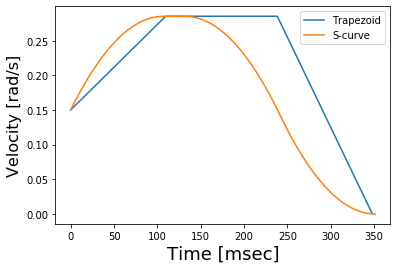

In [604]:
## plot distance versus time to check results
time_x = [0, X_trap.timeAccel, (timeConstVel_x + X_trap.timeAccel), (timeConstVel_x + X_trap.timeAccel + X_trap.timeDeaccel)]
dist_x = [0, X_trap.distAccel, (X_trap.distAccel + distConstVel_x), (X_trap.distAccel + distConstVel_x + X_trap.distDeaccel)]
vel_x  = [v0, X.maxVel, X.maxVel, vf]
plt.plot(time_x, vel_x, label='Trapezoid')
# plt.ylabel('Distance [u]', fontsize=16)
# plt.show()

print("calculated distance:", (xDist),"distance moved:", s[s.size-1])
print("calculated time:", total_time_x,"actual total time:", t[t.size-1])

# Plot values
plt.plot(t, v, label='S-curve')
# plt.plot(t, a)
plt.xlabel('Time [msec]', fontsize=18)
plt.ylabel('Velocity [rad/s]', fontsize=16)
plt.legend()
plt.show()

calculated distance: 68 distance moved: 64.04785194654755
calculated time: 347.87409985569985 actual total time: 351.009


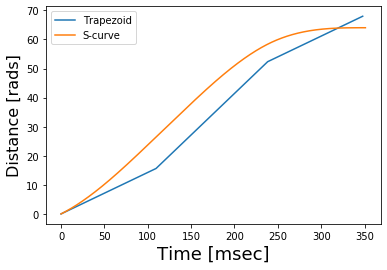

In [605]:
## plot distance versus time to check results
dist_x = [0, X_trap.distAccel, (X_trap.distAccel + distConstVel_x), (X_trap.distAccel + distConstVel_x + X_trap.distDeaccel)]
plt.plot(time_x, dist_x, label='Trapezoid')

print("calculated distance:", (xDist),"distance moved:", s[s.size-1])
print("calculated time:", total_time_x,"actual total time:", t[t.size-1])

# Plot values
plt.plot(t, s, label='S-curve')
# plt.plot(t, a)
plt.xlabel('Time [msec]', fontsize=18)
plt.ylabel('Distance [rads]', fontsize=16)
plt.legend()
plt.show()